BE/Bi 103, Fall 2014: Homework 5
================================
Due 1pm, Monday, November 17
---------------------------

*This document was generated from an IPython notebook.  You can download the notebook [here](hw5_solution.ipynb).*

Before we begin the problem statements and solutions, let's load the necessary functions, as usual.

In [3]:
# As usual, import modules
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals
import json
    
import numpy as np
import scipy.interpolate
import scipy.optimize
import scipy.signal
import scipy.special
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import numdifftools as nd

import emcee
import triangle
from brewer2mpl import qualitative, sequential

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline    

### Problem 5.1 (Microtubule catastrophe and the Gamma distribution, 50 pts)

In [Homework 1](hw1.html), we plotted data of microtubule catastrophe times.  In this problem, we return to the data from the [Gardner, Zanic, et al. paper](../protected/papers/gardner_2011.pdf)  We will carefully analyze the data and make some conclusions about the processes underlying microtubule catastrophe.  You can download the data set [here](../protected/data/gardner_hw5.zip).

In the file `gardner_mt_catastrophe_only_tubulin.csv`, we have observed catastrophe times of microtubules with different concentrations of tubulin.  So, our data set $D$ consists of a set of measurements of the amount of time to catastrophe; $D = \{t_i\}$.  We will consider two models for microtubule catastrophe.  In the first model ($M_1$), our likelihood is

\begin{align}
P(D~|~\lambda, M_1, I) = \prod_{i\in D} \lambda \mathrm{e}^{-\lambda t_i}.
\end{align}

In the second model ($M_2$), the likelihood is 

\begin{align}
P(D~|~r, a, M_2, I) = \prod_{i\in D} \frac{(rt_i)^a}{t_i\,\Gamma(a)}\,\mathrm{e}^{-rt_i},
\end{align}

where $\Gamma(a)$ is the gamma function.

**a)** I have given you the models mathematically as expressions of the likelihoods.  Describe the two models in words.  Give physical descriptions of the meanings of the parameters $\lambda$, $r$, and $a$.

**b)** For the trials where the tubulin concentration is 12 µM (from the file `gardner_mt_catastrophe_only_tubulin.csv`), estimate the values of the parameter $\lambda$ for model 1.  Estimate the value of the parameters $r$ and $a$ for model 2.  *Hint*: Do not compute the gamma function and then take its logarithm when computing the log likelihood.  Instead, use the `scipy.special.gammaln` function to directly compute $\ln \Gamma(a)$.

**c)** Plot the probability density functions (pdf) for each model over a histogram of the data using your most probable parameter values.  Also plot the cumulative density functions (cdf) over the data.  You will need to bin the data for the pdf histogram, but not for the cdf.  *Hint*: If you wish to compute

\begin{align}
P(x;a,r) = \frac{(rx)^a}{x\,\Gamma(a)}\,\mathrm{e}^{-rx},
\end{align}

the gamma distribution, use `scipy.stats.gamma.pdf(x, a, scale=1.0/r)`.  Similarly, use `scipy.stats.gamma.cdf(x, a, scale=1.0/r)` for the gamma cdf.

**d)** Calculate the approximate odds ratio between the two models.  Be careful with your priors!  You should use a proper prior.  For example, if $a$ has a Jeffreys prior, you can assume a minimum and maximum value for $a$.  In this case,

\begin{align}
P(a~|~I) = \frac{1}{a\,\ln\left(a_\mathrm{max}/a_\mathrm{min}\right)}.
\end{align}

**e)** Using whichever model you found more probable when you computed the odds ratio, compute either $\lambda$ or $a$ and $r$ for the other concentrations of tubulin.  Given that microtubules polymerize faster with higher tubulin concentrations, is there anything you can say about the occurance of catastrophe by looking at the values of $\lambda$ or $a$ and $r$ versus tubulin concentration?

**f)** In the files `gardner_mt_catastrophe_kip3.csv` and `gardner_mt_catastrophe_mcak.csv`, there are measurements of catastrophe times in the presence of the kinesins Kip3 and MCAK.  Analyze these data and discuss conclusions about their respective roles in microtubule catastrophe.  *Note*: This part of the problem is intentionally open-ended.  You should think carefully, and perform a complete analysis to draw your conclusions.

### Problem 5.1 solution

**a)** Model 1 assumes an exponential distribution of waiting times for microtubule catastrophe, while Model 2 assumes a gamma distribution.  The exponential distribution describes the waiting time for an event in a memoryless process.  This means that in Model 1, we assume that microtubule catastrophe happens as a one-step process, independently of the age of the microtubule.  The mean waiting time for the event is $\lambda$.  The gamma distribution, $P(t;r,a)$ describes the waiting time for $a$ events, both of which are exponentially distributed with mean waiting time $r$, to happen.  So, in Model 2, we assume that microtubule catastrophe requires more than one events to happen, and that these events happen at the same rate.

**b)** We we'll load in the 12 µM tubulin data and then perform a regression.

In [4]:
# Load the data set
fname = '../data/gardner_et_al/gardner_mt_catastrophe_only_tubulin.csv'
df = pd.read_csv(fname, comment='#')

# Pull our t, and have it sorted for convenience
t = df['12 uM'].dropna().values
t.sort()

For model 1, we assume a likelihood consisting of $n = |D|$ independent exponentially distributed catastrophe times.  We assume a Jeffreys prior for $\lambda$, since we could equally as well parametrized the likelihood with $\lambda^{-1}$.  The log posterior is then

\begin{align}
\ln P(\lambda~|~D,M_1, I) = \text{constant} - (n+1)\ln \lambda
- \lambda\sum_{i\in D} t_i.
\end{align}

We'll first write functions to give the log likelihood, log prior, and log posterior.  We separate out the likelihood and prior because we will need them later when we compute the odds ratio.

In [5]:
# Define likelihood for Model 1
def log_like_exp(lam, t):
    """
    Returns the properly normalized log exponential distribution.
    """
    # Input is an array, so make a scalar
    lam = lam[0]

    # Check for non-negativity (will mess up log calcs)
    if (lam <= 0.0):
        return -np.inf

    return len(t) * np.log(lam) - lam * t.sum()

# Define prior for Model 1
def log_prior_exp(lam):
    # Input is an array, so make a scalar
    lam = lam[0]

    if (lam <= 0.0):
        return -np.inf

    return -np.log(lam)

# Define posterior
def log_post_exp(lam, t):
    return log_like_exp(lam, t) + log_prior_exp(lam)

# Objective function for optimization
def neg_log_post_exp(lam, t):
    return -log_post_exp(lam, t)

Now that we have the objective function for optimization defined, we can use Powell's method to do the optimization.

In [6]:
# Guesses
lam_0 = 0.01 # inv. sec
p0 = np.array([lam_0])

# Perform optimization
res = scipy.optimize.minimize(neg_log_post_exp, p0, args=(t,), 
                              method='Powell')

# Extract parameter value
popt_exp = np.array([res.x])

# Compute Hessian and covariance
hes = jb.hess_nd(log_post_exp, popt_exp, (t,))
cov_exp = -np.linalg.inv(hes)

# Report the result of the parameter estimation
print('Model 1: lambda = {0:.4f} +- {1:.4f} (1/s)'.format(popt_exp[0], 
                                                     np.sqrt(cov_exp[0,0])))

Model 1: lambda = 0.0026 +- 0.0001 (1/s)


/Users/Justin/anaconda/lib/python2.7/site-packages/numdifftools/core.py:753: UserWarning: The stepsize (0.005) is possibly too large!
  warnings.warn('The stepsize (%g) is possibly too large!' % h1[i])


For Model 2, we do a similar procedure.  Assuming Jeffreys priors on $a$ and $r$, the log posterior is

\begin{align}
\ln P(r, a~|~M_2, I) = \text{constant} - \ln a - n\ln\Gamma(a) + (na-1)\ln r 
+ \sum_{i\in D} \left[(a-1)\ln t_i - r t_i\right].
\end{align}

We can code up the log likelihood, log prior, and log posterior in a similar way.

In [7]:
# Define log likelihood for Model 2
def log_like_gamma(p, t):
    """
    Returns log likelihood of properly normalized log gamma distribution.
    """
    # Check for non-negativity (will mess up log calcs)
    if (p <= 0.0).any():
        return -np.inf

    a, r = p
    n = len(t)
    return -n * scipy.special.gammaln(a) + n * a * np.log(r) \
                     + ((a - 1.0) * np.log(t) - r * t).sum()

# Define prior for Model 2
def log_prior_gamma(p):
    if (p <= 0.0).any():
        return -np.inf

    a, r = p
    return -np.log(a * r)
    
# Define posterior
def log_post_gamma(p, t):
    return log_like_gamma(p, t) + log_prior_gamma(p)

# Objective function for optimization
def neg_log_post_gamma(p, t):
    return -log_post_gamma(p, t)

# Guesses
a_0 = 2.0
r_0 = 0.01 # inv. sec
p0 = np.array([a_0, r_0])

# Perform optimization
res = scipy.optimize.minimize(neg_log_post_gamma, p0, args=(t,), 
                              method='Powell')

# Extract parameter value
popt_gamma = res.x

# Compute Hessian and covariance
hes = jb.hess_nd(log_post_gamma, popt_gamma, (t,))
cov_gamma = -np.linalg.inv(hes)

# Report result
print("""
Model 2: a = {0:.4f} +- {1:.4f}
         r = {2:.4f} +- {3:.4f} (1/s)
""".format(popt_gamma[0], np.sqrt(cov_gamma[0,0]), 
           popt_gamma[1], np.sqrt(cov_gamma[1,1])))


Model 2: a = 2.9344 +- 0.1500
         r = 0.0081 +- 0.0005 (1/s)



/Users/Justin/anaconda/lib/python2.7/site-packages/numdifftools/core.py:753: UserWarning: The stepsize (0.01) is possibly too large!
  warnings.warn('The stepsize (%g) is possibly too large!' % h1[i])
/Users/Justin/anaconda/lib/python2.7/site-packages/numdifftools/core.py:753: UserWarning: The stepsize (0.165515) is possibly too large!
  warnings.warn('The stepsize (%g) is possibly too large!' % h1[i])


We see that if Model 2 is correct, there are about three processes responsible for catastrophe.

For fun, we'll consider another distribution, the Weibull distribution, which describes waiting times if $t^\beta$ is exponentially distributed.  This means that there is a constant aging process: the longer we wait, the more likely we are to have catastrophe.  The likelihood in this case, which we'll call Model 3, is

\begin{align}
P(D~|~\beta,\lambda,M_3,I) = \beta \lambda \left(\lambda t\right)^{\beta-1}
\mathrm{e}^{-(\lambda t)^\beta}.
\end{align}

In [8]:
# Define log likelihood for Model 3
def log_like_weibull(p, t):
    """
    Properly normalized log likelihood for Weibull distribution.
    """
    # Check for non-negativity (will mess up log calcs)
    if (p <= 0.0).any():
        return -np.inf

    beta, lam = p
    n = len(t)
    return (beta - 1.0) * np.log(lam * t).sum() + n * np.log(lam * beta) \
                - ((lam * t)**beta).sum()

# Define prior for Model 3
def log_prior_weibull(p):
    if (p <= 0.0).any():
        return -np.inf

    beta, lam = p
    
    return -np.log(lam * beta)
    
# Define posterior
def log_post_weibull(p, t):
    return log_like_weibull(p, t) + log_prior_weibull(p)

# Objective function for optimization
def neg_log_post_weibull(p, t):
    return -log_post_weibull(p, t)

# Guesses
beta_0 = 2.0
lam_0 = 0.01 # inv. sec
p0 = np.array([beta_0, lam_0])

# Perform optimization
res = scipy.optimize.minimize(neg_log_post_weibull, p0, args=(t,), 
                              method='Powell')

# Extract parameter value
popt_weibull = res.x

# Compute Hessian and covariance
hes = jb.hess_nd(log_post_weibull, popt_weibull, (t,))
cov_weibull = -np.linalg.inv(hes)

# Report result
print("""
Model 3: beta   = {0:.4f} +- {1:.4f}
         lambda = {2:.4f} +- {3:.4f} (1/s)
""".format(popt_weibull[0], np.sqrt(cov_weibull[0,0]), 
           popt_weibull[1], np.sqrt(cov_weibull[1,1])))


Model 3: beta   = 1.7540 +- 0.0486
         lambda = 0.0023 +- 0.0001 (1/s)



/Users/Justin/anaconda/lib/python2.7/site-packages/numdifftools/core.py:753: UserWarning: The stepsize (2.02609) is possibly too large!
  warnings.warn('The stepsize (%g) is possibly too large!' % h1[i])
/Users/Justin/anaconda/lib/python2.7/site-packages/numdifftools/core.py:753: UserWarning: The stepsize (0.0025) is possibly too large!
  warnings.warn('The stepsize (%g) is possibly too large!' % h1[i])


**c)** First, we'll bin the data and plot the histogram with the three theoretical curves overlaid.

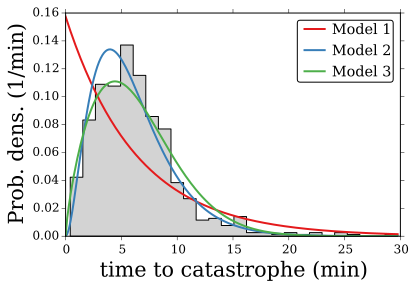

In [7]:
# Bin data for histogram
n, b, p = plt.hist(t / 60.0, bins=np.sqrt(len(t)), normed=True,
                   histtype='stepfilled', color='lightgray')

# Pull out best fit parameters
lam = popt_exp[0]
a, r = popt_gamma
beta, lam_weibull = popt_weibull

# Make smooth curves of fits
t_smooth = np.linspace(0.0, t.max(), 200)
p_exp = lam * np.exp(-lam * t_smooth)
p_gamma = scipy.stats.gamma.pdf(t_smooth, a, scale=1.0/r)
p_weibull = beta * lam_weibull * (lam_weibull * t_smooth)**(beta - 1) \
                * np.exp(-(t_smooth * lam_weibull)**beta)

# Plot smooth curves
bmap = qualitative.Set1[3]
plt.plot(t_smooth / 60.0, p_exp * 60.0, '-', color=bmap.mpl_colors[0], 
         label='Model 1')
plt.plot(t_smooth / 60.0, p_gamma * 60.0, '-', color=bmap.mpl_colors[1],
         label='Model 2')
plt.plot(t_smooth / 60.0, p_weibull * 60.0, '-', color=bmap.mpl_colors[2], 
         label='Model 3')
plt.legend(loc='upper right')
plt.xlabel('time to catastrophe (min)')
plt.ylabel('Prob. dens. (1/min)')

We'll now plot them over the cumulative distributions.  We can use our code from [Homework 1](../protected/hw_solutions/hw1_solution.html) to plot the CDFs from the experimental data.  We can compute the cumulative histograms for the exponential and Weibull distributions as follows.

\begin{align}
\int_0^t \mathrm{d}t' \,\lambda \mathrm{e}^{-\lambda t'} &= 1 - \mathrm{e}^{-\lambda t},\\[1mm]
\int_0^t \mathrm{d}t' \,\beta\lambda\,(\lambda t)^{\beta-1} \,\mathrm{e}^{-(\lambda t')^\beta} 
&= \int_0^{(\lambda t)^\beta} \mathrm{d}u \, \mathrm{e}^{-u}
= 1 - \mathrm{e}^{-(\lambda t)^\beta},
\end{align}

where we have made the substitution $u = (\lambda t')^\beta$ in the second integral.

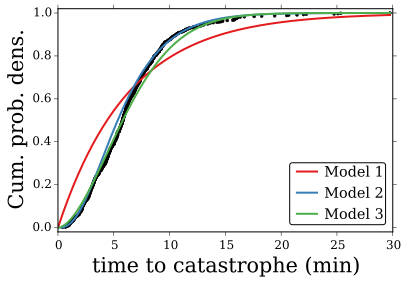

In [8]:
# We already sorted the data, so we just have to make the y-axis
p_exp = np.arange(1, len(t)+1) / float(len(t))

# Compute cumulative histograms of fits
p_exp_cum = 1.0 - np.exp(-(lam  * t_smooth))
p_gamma_cum = scipy.stats.gamma.cdf(t_smooth, a, scale=1.0/r)
p_weibull_cum = 1.0 - np.exp(-(lam_weibull * t_smooth)**beta)

# Plot the results
plt.plot(t / 60.0, p_exp, 'k.')
plt.plot(t_smooth / 60.0, p_exp_cum, '-', color=bmap.mpl_colors[0], 
         label='Model 1')
plt.plot(t_smooth / 60.0, p_gamma_cum, '-', color=bmap.mpl_colors[1], 
         label='Model 2')
plt.plot(t_smooth / 60.0, p_weibull_cum, '-', color=bmap.mpl_colors[2], 
         label='Model 3')
plt.margins(y=0.02)
plt.legend(loc='lower right')
plt.xlabel('time to catastrophe (min)')
plt.ylabel('Cum. prob. dens.')

The "by eye" test, especially of the cumulative data, suggests that Model 2 is the best fit.  But, never rely on the by eye test!  Compute an odds ratio!

**d)** To compute the odds ratio between two models, we use the equation derived in lecture and presented in [Tutorial 4b](../tutorials/t4b_model_selection.html),

\begin{align}
O_{12} &= \frac{P(M_1~|~I)}{P(M_2~|~I)}\frac{P(D~|~M_1,I)}{P(D~|~M_2,I)}
\approx\frac{P(M_1~|~I)}{P(M_2~|~I)}\,
\frac{P(D~|~\mathbf{a}_1^*,M_1,I)}{P(D~|~\mathbf{a}_2^*,M_2,I)}\,
\frac{P(\mathbf{a}_1^*~|~M_1,I)}{P(\mathbf{a}_2^*~|~M_2,I)} \,
\sqrt{\frac{\det \sigma_1^2}{\det \sigma_2^2}}.
\end{align}

Here, $\mathbf{a}_i^*$ are the most probable parameters for model $i$.  We approximate the posterior probability $P(\mathbf{a}_i~|~D,M_i,I)$ as Gaussian with covariance $\sigma_i^2$ and use Laplace's approximation to evaluate

\begin{align}
P(D~|~M_i,I) = \int \mathrm{d}\mathbf{a}_i\,P(D~|~\mathbf{a}_i,M_i, I)\,P(\mathbf{a}_i~|~M_i,I).
\end{align}

In computing our odds ratios, we assume we have no priori preference for any one model, so we take $P(M_1~|~I) \approx P(M_2~|~I) \approx P(M_3~|~I)$.  Then, for comparison of Model 1 and Model 2, we have

\begin{align}
O_{12} &\approx\frac{P(D~|~\lambda_1^*,M_1,I)}{P(D~|~a^*, r^*,M_2,I)}\,
\frac{(\lambda^*)^{-1}\ln(\lambda_\mathrm{max} / \lambda_\mathrm{min})}
{(a^* r^*)^{-1}\ln(a_\mathrm{max} / a_\mathrm{min})\ln(r_\mathrm{max} / r_\mathrm{min})} \,
\sqrt{\frac{\det \sigma_1^2}{\det \sigma_2^2}}.
\end{align}

We need to make choices for the ranges that $\lambda$, $r$, and $a$ can take.  $\lambda$ and $r$ are related; they are the average rate at which events leading to catastrophe take place.  Since catastrophe happens, it probably happens at least once during a cell cycle, so a lower bound on $\lambda$ and $r$ would be one inverse hour, or $1/3600\text{ s}^{-1} \approx 10^{-4} \text{ s}^{-1}$.  For an upper bound on the rate, we know that long microtubules exist, and a ridiculously fast growth rate would be a micron per second.  So, the fastest rate would be about $0.1\text{ s}^{-1}$, meaing that catastrophes on average happen every 10 seconds or so.  So,

\begin{align}
\ln(\lambda_\mathrm{max} / \lambda_\mathrm{min}) \approx \ln(r_\mathrm{max} / r_\mathrm{min}) \approx \ln \left(10^3\right).
\end{align}

Now, $a$ is roughly the numberof processes that must happen for catastrophe.  A lower bound is $a = 1$.  A microtubule consists of 14 protofilaments.  A reasonable upper bound on $a$ might then be 14.  Or, if we are being overly cautious, we could tack on an extra order of magnitude and say $a_\mathrm{max} \approx 10^2$.  Thus, $\ln(a_\mathrm{max} / a_\mathrm{min}) \approx \ln 100$.

It is easier to compute the log of the odds ratio, so we will do that.

In [9]:
# Define ranges for parameters
lam_min = r_min = 1e-4  # inv. s
lam_max = r_max = 0.1   # inv. s
a_min = 1.0
a_max = 100.0

# Compute components of log odds ratio
log_likelihood_ratio = log_like_exp(popt_exp, t) \
                            - log_like_gamma(popt_gamma, t)

log_prior_ratio = log_prior_exp(popt_exp) - log_prior_gamma(popt_gamma) \
                        - np.log(np.log(lam_max / lam_min)) \
                        + np.log(np.log(r_max / r_min)) \
                        + np.log(np.log(a_max / a_min))

log_cov_ratio = 0.5 * np.log(np.linalg.det(cov_exp)) \
                        - 0.5 * np.log(np.linalg.det(cov_gamma))

# Put the pieces together
log_odds_ratio = log_likelihood_ratio + log_prior_ratio + log_cov_ratio

# Compute the base 10 log
log10_odds_ratio = log_odds_ratio / np.log(10)

print('log10(odds_ratio) = %.1f' % log10_odds_ratio)

log10(odds_ratio) = -68.9


Wow!  The odds ratio is

\begin{align}
O_{12} \approx 10^{-69},
\end{align}

meaning that the data overwhelmingly favor Model 2, even though it has an extra parameter.

Now, let's try $O_{23}$.  We use the same procedure.  We assume the same limits on $\lambda$ for the Weibull distribution as for $r$ in the gamma distribution.  For $\beta$, the lower bound is $\beta = 1$ (no aging).  If microtubules age strongly, we might massively overestimate $\beta = 10$.

In [10]:
# Define ranges for parameters
lam_min = r_min = 1e-4  # inv. s
lam_max = r_max = 0.1   # inv. s
a_min = 1.0
a_max = 100.0
beta_min = 1.0
beta_max = 10.0

# Compute components of log odds ratio
log_likelihood_ratio = log_like_gamma(popt_gamma, t) \
                            - log_like_weibull(popt_weibull, t)

log_prior_ratio = log_prior_gamma(popt_gamma) \
                        - log_prior_weibull(popt_weibull) \
                        - np.log(np.log(r_max / r_min)) \
                        - np.log(np.log(a_max / a_min)) \
                        + np.log(np.log(beta_max / beta_min))

log_cov_ratio = 0.5 * np.log(np.linalg.det(cov_gamma)) \
                        - 0.5 * np.log(np.linalg.det(cov_weibull))

# Put the pieces together
log_odds_ratio = log_likelihood_ratio + log_prior_ratio + log_cov_ratio

# Compute the base 10 log
log10_odds_ratio = log_odds_ratio / np.log(10)

print('log10(odds_ratio) = %.1f' % log10_odds_ratio)

log10(odds_ratio) = 5.5


We see that Model 2 is about $10^6$ times more probable than Model 3.  This suggests that the non-exponential behavior of the waiting times for microtubule catastrophe is not due to aging of microtubules, but rather due to multiple processes.  Or, as the authors in the paper put it, the "aging" process is defined by multiple ($\approx 3$) processes, as opposed to a constant aging process described by the Weibull distribution.

As an exercise, you can try adjusting the values of $a_\mathrm{min}$, $a_\mathrm{max}$, etc., and you can see that for any reasonable values, the resulting odds ratio changes very little.  This is because the effect of the prior ranges are damped by taking logarithms.

**e)** We will use Model 2 (gamma distributed catastrophe times) going forward.  We take exactly the same approach as before.  For convenience, we'll write a function to analyze all of the columns in a data frame at once, dumping the results into new DataFrames that contain the best fit parameters and the error bars.

In [11]:
def fit_df(df, dist, p0):
    """
    Fit gamma distributions for each column in a DataFrame, using initial
    guesses a_0, r_0.
    
    dist = 'gamma', 'exp', or 'weibull'
    """
    # Make indices and negative log posterior based on distribution
    if dist == 'gamma':
        index = ['a', 'r']
        neg_log_post_fun = neg_log_post_gamma
        log_post_fun = log_post_gamma
    elif dist == 'exp':
        index = ['lambda']
        neg_log_post_fun = neg_log_post_exp
        log_post_fun = log_post_exp
    elif dist == 'weibull':
        index = ['beta', 'lambda']
        neg_log_post_fun = neg_log_post_weibull
        log_post_fun = log_post_weibull
   
    # Make a DataFrames for the results
    df_fit = pd.DataFrame(columns=df.columns, index=index)
    df_err = pd.DataFrame(columns=df.columns, index=index)
    
    # Loop through MT lengths and do regression
    for col in df.columns:
        # Pull our time values
        t = df[col].dropna().values
    
        # Perform optimization
        res = scipy.optimize.minimize(neg_log_post_fun, p0, args=(t,), 
                                      method='Powell')

        # Extract parameter value
        popt = res.x
    
        # Compute Hessian and covariance
        hes = jb.hess_nd(log_post_fun, popt, (t,))
        cov = -np.linalg.inv(hes)
    
        # Put in DataFrames
        df_fit[col] = popt
        df_err[col] = np.diag(np.sqrt(cov))

    return df_fit, df_err

With this function in hand, we can analyze our full DataFrame.

In [12]:
# Rearrange DataFrame columns for convenience
cols = ['7 uM', '9 uM', '10 uM', '12 uM', '14 uM']
df = df[cols]

# Initial guess
p0 = np.array([2.0, 0.01])

# Do parameter estimations
df_fit, df_err = fit_df(df, 'gamma', p0)

# Report result
for col in df.columns:
    print("""
    {0:s}: a = {1:.4f} +- {2:.4f}
           r = {3:.4f} +- {4:.4f} (1/s)
    """.format(col, df_fit[col]['a'], df_err[col]['a'], 
               df_fit[col]['r'], df_err[col]['r']))


    7 uM: a = 2.4297 +- 0.1313
           r = 0.0075 +- 0.0005 (1/s)
    

    9 uM: a = 2.8038 +- 0.2367
           r = 0.0094 +- 0.0009 (1/s)
    

    10 uM: a = 3.4112 +- 0.3104
           r = 0.0097 +- 0.0010 (1/s)
    

    12 uM: a = 2.9344 +- 0.1500
           r = 0.0081 +- 0.0005 (1/s)
    

    14 uM: a = 3.1622 +- 0.3632
           r = 0.0072 +- 0.0009 (1/s)
    


Let's plot the results as bar graphs.

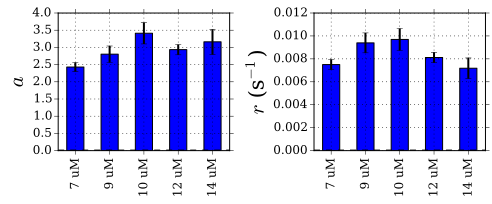

In [13]:
# Set up figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(7,3))

# Use pandas plotting for bar graphs, first for a
df_fit.swapaxes(0,1)['a'].plot(kind='bar', ax=ax[0], 
                               yerr=df_err.swapaxes(0,1)['a'])
ax[0].set_ylabel(r'$a$')

# Bar graph for r
df_fit.swapaxes(0,1)['r'].plot(kind='bar', ax=ax[1], 
                               yerr=df_err.swapaxes(0,1)['r'])
ax[1].set_ylabel('$r$ (s$^{-1}$)')

# Make the spacing nice so axis labels don't overlap
fig.tight_layout()

There is some variation between tubulin concentrations in the number of steps and also the rate of catastrophe.  The two do not seem to be correlated.  Nonetheless, neither the number of processes nor rate differs by more than about 30%.  Strikingly, the rate of catastrophe is the same for 7 µM tubulin as it is for 14 µM tubulin.  Together, these suggests that the number of processes for catastrophe is three and that the the rate is roughly $10^{-2} \text{ s}^{-1}$, and both are independent of tubulin concentration.  Because microtubules grow faster with more tubulin, catastrophe is also independent of microtubule length.

**f)** We do the same analysis as before with these two data sets.  We'll first analyze the Kip3 data set.

In [14]:
# Load the data set
fname = '../data/gardner_et_al/gardner_mt_catastrophe_kip3.csv'
df_kip3 = pd.read_csv(fname, comment='#')

# Initial guess
p0 = np.array([2.0, 0.01])

# Do parameter estimations
df_kip3_fit, df_kip3_err = fit_df(df_kip3, 'gamma', p0)

# Report result
for col in df_kip3.columns:
    print("""
    {0:s}: a = {1:.4f} +- {2:.4f}
                r = {3:.4f} +- {4:.4f} (1/s)
    """.format(col, df_kip3_fit[col]['a'], df_kip3_err[col]['a'], 
               df_kip3_fit[col]['r'], df_kip3_err[col]['r']))


    18 nM Kip3: a = 2.6288 +- 0.2239
                r = 0.0157 +- 0.0015 (1/s)
    

    14 nM Kip3: a = 2.7253 +- 0.2249
                r = 0.0102 +- 0.0009 (1/s)
    

    7 nM Kip3: a = 2.4287 +- 0.2389
                r = 0.0082 +- 0.0009 (1/s)
    


Before commenting on these results, we'll do a similar analysis for MCAK.

In [15]:
# Load the data set
fname = '../data/gardner_et_al/gardner_mt_catastrophe_mcak.csv'
df_mcak = pd.read_csv(fname, comment='#')

# Initial guess
p0 = np.array([2.0, 0.01])

# Make a DataFrames for the results
df_mcak_fit, df_mcak_err = fit_df(df_mcak, 'gamma', p0)

# Report result
for col in df_mcak.columns:
    print("""
    {0:s}: a = {1:.4f} +- {2:.4f}
               r = {3:.4f} +- {4:.4f} (1/s)
    """.format(col, df_mcak_fit[col]['a'], df_mcak_err[col]['a'], 
               df_mcak_fit[col]['r'], df_mcak_err[col]['r']))


    9 nM MCAK: a = 1.2879 +- 0.0819
               r = 0.0065 +- 0.0005 (1/s)
    

    7 nM MCAK: a = 1.5533 +- 0.1212
               r = 0.0066 +- 0.0006 (1/s)
    

    5 nM MCAK: a = 1.4814 +- 0.1028
               r = 0.0069 +- 0.0006 (1/s)
    

    2.4 nM MCAK: a = 1.6438 +- 0.1660
               r = 0.0044 +- 0.0005 (1/s)
    


Now let's plot the results.

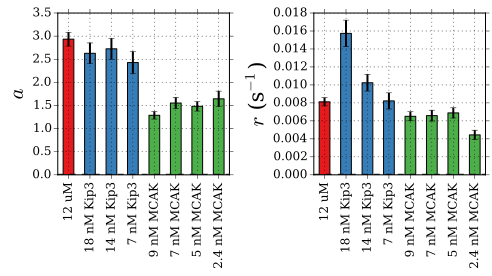

In [16]:
# Set up figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(7,4))

# Merge the no motor, Kip3, and MCAK data frames
df_motor_fit = pd.concat((df_fit['12 uM'], df_kip3_fit, df_mcak_fit), axis=1)
df_motor_err = pd.concat((df_err['12 uM'], df_kip3_err, df_mcak_err), axis=1)

# Make colors for bars
bar_colors = [bmap.mpl_colors[0]] + df_kip3.shape[1] * [bmap.mpl_colors[1]] \
             + df_mcak.shape[1] * [bmap.mpl_colors[2]] \

# Use pandas plotting for bar graphs, first for  a
df_motor_fit.swapaxes(0,1)['a'].plot(kind='bar', ax=ax[0], 
                                    yerr=df_motor_err.swapaxes(0,1)['a'],
                                    color=bar_colors)
ax[0].set_ylabel(r'$a$')

# Bar graph for MCAK a
df_motor_fit.swapaxes(0,1)['r'].plot(kind='bar', ax=ax[1], 
                                     yerr=df_motor_err.swapaxes(0,1)['r'],
                                     color=bar_colors)
ax[1].set_ylabel(r'$r$ (s$^{-1}$)')

# Make the spacing nice so axis labels don't overlap
fig.tight_layout()

We see that Kip3 does not affect the number of processes required to induce catastrophe, but increases the rate of catastrophe in a concentration dependent manner.  MCAK, on the other hand, reduces the number of processes required for catastrophe.  The rate of catastrophe is slightly lower than in the absense of MCAK, but not as dramatically so as in the presense of Kip3.

To make a fuller interpretation of these data, the authors also investigated microtubule age and growth rate, as these motor proteins are known to have affects on microtubule polymerization rate (Kip3) and on catastrophe induction (MCAK).  We will not go into that here.  Instead, we will see if catastrophe in the presense of MCAK can indeed be described with an exponential distribution, suggesting a single memoryless stochastic process that induces catastrophe.  We will do the analysis for the 9 nM MCAK concentration.

In [17]:
# First do exponential model
# Guesses
lam_0 = 0.01 # inv. sec
p0 = np.array([lam_0])

# Pull out time points
t = df_mcak['9 nM MCAK'].dropna().values

# Perform optimization
res = scipy.optimize.minimize(neg_log_post_exp, p0, args=(t,), 
                              method='Powell')

# Extract parameter value
popt_mcak_exp = np.array([res.x])

# Compute Hessian and covariance
hes = jb.hess_nd(log_post_exp, popt_mcak_exp, (t,))
cov_mcak_exp = -np.linalg.inv(hes)

# Report the result of the parameter estimation
print('Model 1: lambda = {0:.4f} +- {1:.4f} (1/s)'.format(
            popt_mcak_exp[0], np.sqrt(cov_mcak_exp[0,0])))


# Now do gamma model
# Guesses
p0 = np.array([2.0, 0.01])

# Perform optimization
res = scipy.optimize.minimize(neg_log_post_gamma, p0, args=(t,), 
                              method='Powell')

# Extract parameter values
popt_mcak_gamma = res.x

# Compute Hessian and covariance
hes = jb.hess_nd(log_post_gamma, popt_mcak_gamma, (t,))
cov_mcak_gamma = -np.linalg.inv(hes)

# Report result
print("""
Model 2: a = {0:.4f} +- {1:.4f}
         r = {2:.4f} +- {3:.4f} (1/s)
""".format(popt_mcak_gamma[0], np.sqrt(cov_mcak_gamma[0,0]), 
           popt_mcak_gamma[1], np.sqrt(cov_mcak_gamma[1,1])))


Model 1: lambda = 0.0051 +- 0.0003 (1/s)

Model 2: a = 1.2879 +- 0.0819
         r = 0.0065 +- 0.0005 (1/s)



We can now do model selection.

In [18]:
# Define ranges for parameters
lam_min = r_min = 1e-4  # inv. s
lam_max = r_max = 0.1   # inv. s
a_min = 1.0
a_max = 100.0

# Compute components of log odds ratio
log_likelihood_ratio = log_like_exp(popt_mcak_exp, t) \
                            - log_like_gamma(popt_mcak_gamma, t)

log_prior_ratio = log_prior_exp(popt_mcak_exp) \
                        - log_prior_gamma(popt_mcak_gamma) \
                        - np.log(np.log(lam_max / lam_min)) \
                        + np.log(np.log(r_max / r_min)) \
                        + np.log(np.log(a_max / a_min))

log_cov_ratio = 0.5 * np.log(np.linalg.det(cov_mcak_exp)) \
                        - 0.5 * np.log(np.linalg.det(cov_mcak_gamma))

# Put the pieces together
log_odds_ratio = log_likelihood_ratio + log_prior_ratio + log_cov_ratio

# Compute the base 10 log
log10_odds_ratio = log_odds_ratio / np.log(10)

print('log10(odds_ratio) = %.1f' % log10_odds_ratio)

log10(odds_ratio) = -1.5


We see that the gamma distribution is still more likely, but the odds ratio is not as strong as for the non-MCAK case.  A plausible interpretation is that MCAK induces catastrophe in a memoryless stochastic way, but that the multi-step catastrophe process native to microtubules is still going on.  Testing this hyopthesis would require further experiments.  This is how the cycle goes: do analysis and reformulate hypotheses and new ways to test them.

Finally, for fun, we'll do MCMC to estimate parameters for Model 2 for the pure tubulin data.

In [19]:
# MCMC for gamma
# Define walker settings
n_dim = 2        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 500    # "burn-in" period to let chains stabilize
n_steps = 5000 # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
# We'll randomize in a Gaussian fashion about our guesses.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(1.0, n_walkers)            # a
p0[:,1] = np.random.exponential(0.01, n_walkers)           # r

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_gamma, 
                                args=(df['12 uM'],))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

With the results in hand, we can plot the posterior distribution.

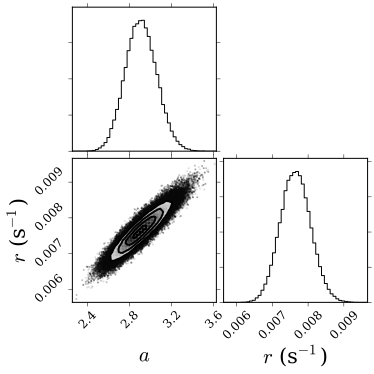

In [20]:
triangle.corner(sampler.flatchain, labels=['$a$', '$r$ (s$^{-1}$)']);

<br />
<br />

### Problem 5.2 (Oscillating reactions in droplets, 50 pts)

In this problem, we will be analyzing data from [Weitz, et al., Diversity in the dynamical behaviour of a compartmentalized programmable biochemical oscillator, *Nature Chemistry*, **6**, 295-302, 2014](http://bebi103.caltech.edu/2014/protected/papers/weitz_2014.pdf).  As discussed in [Tutorial 5b](http://bebi103.caltech.edu/2014/tutorials/t5b_data_smoothing.html), the authors engineered a synthetic two-switch negative-feedback oscillator circuit.  When the components of this circuit are mixed together, the concentrations of the respective species oscillate in time.  The concentration is reported by a fluorescently labeled DNA strand whose base-pairing state affects the fluorescent signal.  

The authors did this experiment in bulk solution and observed oscillations.  Interestingly, the also encapsulated the reaction mixture in small droplets ranging from 33 to 16000 cubic microns.  They observe differences in the oscillation period and amplitude in the small droplets when compared to bulk.  This highlights the effect that statistical variation in the concentration of components in the droplets can have on observed dynamics.  Understanding these effects are important as we seek to engineer cell-scale systems.

In doing this problem, the Data Analysis section of the supplement of the paper (pages 8-14) will be useful to you.

The data sets for this problem contain the area and integrated fluorescent intensity of droplets over time.  There are a total of seven sets taken from drops showing sustained oscillations.  The file names are organized as such:

`area_1.csv`: Each column has the area of a given droplet.  This is $x_{area,i}$ as defined in the paper.

`intensity_1.csv`: Each column has the Alex488 fluorescent signal from the reaction network.  This is $x_{fl,i}$ as defined in the paper.

`intensity_norm_1.csv`: Each column has the TexasRed signal.  This is used to nroamlize the fluorescent signal.  This is $x_{norm,i}$ in the paper.

In all of these CSV files, the first column is labeled `SliceNumber`.  This simply give the number of the image from which the data were taken.  The frame rate in these experiments was five minutes per frame (or 12 frames per hour).  So, `SliceNumber` 3 means $t = 10$ minutes.

In this problem, you will work on your scripting skills to deal with large data sets that have many trials, in addition to using smoothing techniques.

**a)** Load the data (from [this ZIP file](http://bebi103.caltech.edu/2014/protected/data/hw5_oscillating_data.zip)) and construct a data set that has all of the "good" traces of droplet fluorescence you want to consider.  This means you will remove traces that have problems.  For example, you will want to remove traces that are too short, as this is indicative that droplet tracking failed.  You should find the discussion in the supplement very useful in how to define good traces, though you may come up with your own definitions of good traces.  *Hint*: You may find some of the functions in `pandas` useful.  `pd.concat` and `pd.rolling_median` may help.  If `df` is a DataFrame, the methods `df.diff` and `df.quantile` may also be useful.  Furthermore, `df.ix` is useful because it allow indexing like NumPy arrays.

**b)** Using your good set of traces, smooth the traces and find the period of oscillation for each trace.  This should be calculated as $T_{n,m}$ as defined on page 10 of the supplement.

**c)** Plot $T_{3,1}$ versus radius of for your good data and provide any comments you may have.

### Problem 5.2: solution

**a)** We can use DataFrames and all the magic functions they have to do the filtering of the data sets.  We'll start by loading all the data sets and them merging them together to for one DataFrame each for the area, intensity, and reference intensity data.  We will also pull out the time points and keep them separate so that the DataFrames only include information about the droplets and not the time points.

In [2]:
dir = '../data/weitz_et_al/sustained/experiment/hw5_oscillating_data/'

# Read all data and join df's
df_area = pd.read_csv(dir + 'area_1.csv', comment='#')
df_fl = pd.read_csv(dir + 'intensity_1.csv', comment='#')
df_norm = pd.read_csv(dir + 'intensity_norm_1.csv', comment='#')

# Pull out minutes
t = (df_area.ix[:,0] - 1.0) * 5.0

# Only store data in DataFrames (not time)
df_area = df_area.ix[:,1:]
df_fl = df_fl.ix[:,1:]
df_norm = df_norm.ix[:,1:]

# Concatenate DataFrames to put all data together
for i in range(2, 8):
    fname = dir + 'area_' + str(i) + '.csv'
    df = pd.read_csv(fname, comment='#')
    df_area = pd.concat((df_area, df.ix[:,1:]), axis=1, ignore_index=True)
    
    fname = dir + 'intensity_' + str(i) + '.csv'
    df = pd.read_csv(fname, comment='#')
    df_fl = pd.concat((df_fl, df.ix[:,1:]), axis=1, ignore_index=True)

    fname = dir + 'area_' + str(i) + '.csv'
    df = pd.read_csv(fname, comment='#')
    df_norm = pd.concat((df_norm, df.ix[:,1:]), axis=1, ignore_index=True)

Now, we'll cut out any traces that have zero values in them for area, intesity, or reference intensity.

In [3]:
# Find columns with no zeros
inds = ((df_area != 0).all(axis=0)) & ((df_fl != 0).all(axis=0)) \
        & ((df_norm != 0).all(axis=0))
    
# Only keep columns where intensity never goes to zero
df_area = df_area.ix[:, inds]
df_fl = df_fl.ix[:, inds]
df_norm = df_norm.ix[:, inds]

Now, we'll look at the area traces to make sure that there are no jumps in measured area.  This is what happens when image segmentation fails.  To do this, we first perform a median filter on the area traces (with filter window of 55 minutes), as suggested in the paper.  We then compute the derivatives of the filtered area traces by forward differencing.  If any of the derivatives jumps above 5$\times$ the 90% quantile of the deriviative, we identify it as a segmentation failure and cut the trace from consideration.

In [4]:
# Median filter on area
df_area_filt = pd.rolling_median(df_area.ix[:,1:], 11, center=True)
df_area_filt.dropna(axis=0, inplace=True)

# Compute derivatives
df_area_filt_diff = np.abs(df_area_filt.diff())
df_area_filt_diff.dropna(axis=0, inplace=True)

# Obtain 90% quantile
quant_90 = df_area_filt_diff.quantile(0.9, axis=0)

# Get indices where derivative is 5x 90% quantile
good_inds = (df_area_filt_diff < 5.0 * quant_90).all()

# Only keep good traces
df_area = df_area.ix[:, good_inds]
df_fl = df_fl.ix[:, good_inds]
df_norm = df_norm.ix[:, good_inds]

We do a similar analysis on the reference fluorescence traces to make sure there were no jumps there.

In [5]:
# Median filter on reference fluorescence
df_norm_filt = pd.rolling_median(df_norm, 11, center=True)
df_norm_filt.dropna(axis=0, inplace=True)

# Compute derivatives
df_norm_filt_diff = np.abs(df_norm_filt.diff())
df_norm_filt_diff.dropna(axis=0, inplace=True)

# Obtain 90% quantile
quant_90 = df_norm_filt_diff.quantile(0.9, axis=0)

# Get indices where derivative is 5x 90% quantile
good_inds = (df_norm_filt_diff < 5.0 * quant_90).all()

# Only keep good traces
df_area = df_area.ix[:, good_inds]
df_fl = df_fl.ix[:, good_inds]
df_norm = df_norm.ix[:, good_inds]

We do a similar analysis on the fluorescence signal traces to make sure there were no jumps there.  We will use the normed fluorescence signal to compute the derivatives.

In [6]:
# Median filter on fluorescence
df_fl_filt = pd.rolling_median(df_fl / df_norm, 11, center=True)
df_fl_filt.dropna(axis=0, inplace=True)

# Compute derivatives
df_fl_filt_diff = np.abs(df_fl_filt.diff())
df_fl_filt_diff.dropna(axis=0, inplace=True)

# Obtain 90% quantile
quant_90 = df_fl_filt_diff.quantile(0.9, axis=0)

# Get indices where derivative is 5x 90% quantile
good_inds = (df_fl_filt_diff < 5.0 * quant_90).all()

# Only keep good traces
df_area = df_area.ix[:, good_inds]
df_fl = df_fl.ix[:, good_inds]
df_norm = df_norm.ix[:, good_inds]

# Define a new DataFrame for the normalized signal
df = df_fl / df_norm

Next, we will evaluate the signal to noise ratio.  A droplet with an oscillating reaction will have a large signal to noise ratio, whereas a droplet with a flatlined reaction will have a high signal to noise ratio.  We have to be careful in how we define signal and noise.  The method presented in the paper is reasonable.  We first perform a strong Gaussian filter to get the background.  We subtract the background to get a background subtracted trace.  Then, we smooth the data to get the signal.  I.e., we define the signal as the smoothed data.  The noise is then the difference between the smoothed curve and the background-subtracted data.  The signal to noise ratio is the ratio of the standard deviation in the smoothed curve to that in the unfiltered background-subtracted data.  This is roughly the ratio of the variation in the "real" signal to that in the oberved data.  If this ratio is less than 0.5, we discard the trace.

For our background calculation, we will choose a Gaussian kernel with a standard deviation of 250 minutes, which is longer than observed periods.  For the Epanechnikov kernel to smooth the background-subtracted trace, we choose a $\lambda = 40$ minutes, and this is shorter than typical periods, but long enough to erase smaller fluctuations in the traces.

In [7]:
# Do a strong Gaussian blur to get background and subtract it
for col in df.columns:
    bg = jb.nw_kernel_smooth(t, t, df[col], jb.gauss_kernel, lam=250.0)
    df[col] -= bg
    
# Smooth the data using an Epanechnikov filter with 60 minute window
# Store results in new DataFrame
df_smooth = pd.DataFrame()
for col in df.columns:
    df_smooth[col] = jb.nw_kernel_smooth(t, t, df[col], jb.epan_kernel, 
                                         lam=60.0)

We can now compute the signal to noise ratios.

In [8]:
# Loop through and compute signal to noise ratio, keeping those > 0.5
good_cols = []
for col in df.columns:
    signal_to_noise = df_smooth[col].std() / df[col].std()
    if signal_to_noise > 0.5:
        good_cols.append(col)

# Only keep good ones
df = df[good_cols]
df_smooth = df_smooth[good_cols]

Let's see what we have now.

Number of traces = 574


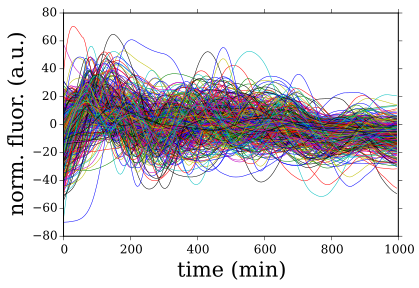

In [9]:
# Number of traces we have
print('Number of traces = %d' % df.shape[1])

# Normalized fluorescent signal
plt.plot(t, df_smooth, '-', lw=0.5);
plt.xlabel('time (min)')
plt.ylabel('norm. fluor. (a.u.)');

**b)** We first need to find the extrema.  We will use a similar technique as in [Tutorial 6a](http://bebi103.caltech.edu/2014/protected/tutorials/t6a_prepping_images.html) to identify peaks, since we've already done much of the smoothing.  Specifically, we will do the following to each trace.  Specifically, we will
identify maxima according to the criteria that a relative maximum in the background-subtracted signal is above zero and either has a relative minimum or boundary (time 0 or time 1000 minutes) below zero on either side.  We will only keep traces that have two or more good maxima.

In [10]:
# Set up DataFrame to store results
df_maxinds = pd.DataFrame()

for col in df_smooth.columns:
    # Extract values as NumPy array.
    fl = df_smooth[col].values
    
    # Find maxes and mins
    max_inds = scipy.signal.argrelmax(fl)[0]
    min_inds = scipy.signal.argrelmin(fl)[0]
    
    # If first index is minimum, add it to min_inds, otherwise to max_inds
    if fl[0] < fl[1]:
        min_inds = np.concatenate(((0,), min_inds))
    elif fl[0] > fl[1]:
        max_inds = np.concatenate(((0,), max_inds))
    
    # Number of maxima and minima
    n_max = len(max_inds)
    n_min = len(min_inds)

    # Find out if min is first
    min_first = max_inds[0] > min_inds[0]

    # Only keep max if it is above zero and min to left and right below 0
    if min_first:
        good_max_inds = (fl[max_inds[:-1]] > 0.0) \
                        & (fl[min_inds[:n_max-1]] < 0.0)\
                        & (fl[min_inds[1:n_max]] < 0.0)
        max_inds = max_inds[good_max_inds]
    else:
        good_max_inds = (fl[max_inds[1:-1]] > 0.0) \
                        & (fl[min_inds[:n_max-2]] < 0.0) \
                        & (fl[min_inds[1:n_max-1]] < 0.0)
        max_inds = max_inds[1:][good_max_inds]

    if len(max_inds) >= 2:
        df_maxinds[col] = pd.Series(max_inds)

Now, for each good trace we have, we will compute $T_{3,1}$, as was used in the paper to identify the oscillation frequency.  This is just the difference between the first and second maxima.

In [11]:
# Set up Series to hold results
s_T31 = pd.Series(index=df_maxinds.columns)

# Multiply by 5 to get in units of minutes
for col in df_maxinds.columns:
    s_T31[col] = (df_maxinds[col][1] - df_maxinds[col][0]) * 5.0

Now that we have what we are after, we can plot oscillation frequency vs. droplet size.

**c)** First, we have to compute the radii of the particles.  We do this as prescribed in the paper on page 8 of the supplement.

In [12]:
# Make Series for radii
s_radii = pd.Series(index=df_maxinds.columns)

# Compute radius as average over areas
for col in df_maxinds.columns:
    s_radii[col] = np.sqrt(df_area[col] / np.pi).mean()

Now we can plot the result.

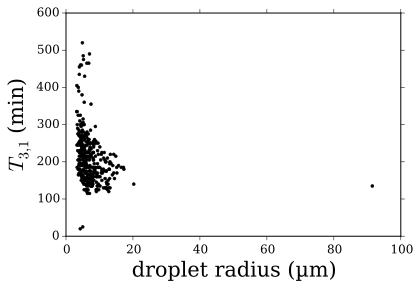

In [13]:
# Plot period vs droplet radius.
plt.plot(s_radii, s_T31, 'k.')
plt.xlabel(u'droplet radius (µm)')
plt.ylabel('$T_{3,1}$ (min)')

We see that we have one absurdly large droplet, and that we probably should have rejected two traces as bad, which gave us very fast oscillations.  We'll scale the plot for a better view.

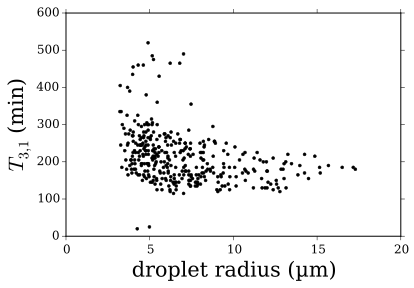

In [15]:
# Plot period vs droplet radius.
plt.plot(s_radii, s_T31, 'k.')
plt.xlabel(u'droplet radius (µm)')
plt.ylabel('$T_{3,1}$ (min)')
plt.xlim((0.0, 20.0));

There appears to be an anti-correlation between droplet size and period of oscillation.  This is perhaps more apparent in Fig. 5a of [the paper](http://bebi103.caltech.edu/2014/protected/papers/weitz_2014.pdf), where the data are binned.  We can do a similar binning.  Again, it will be easier if we use a DataFrame.

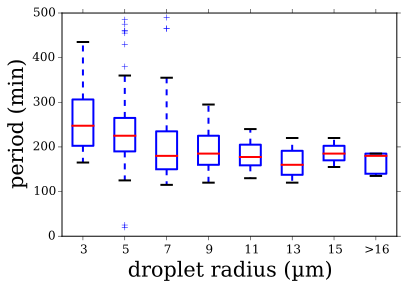

In [16]:
# Make Data Frame
df_good = pd.DataFrame({'T31': s_T31, 'radius': s_radii})

# Set up bin boundaries (2, 4, 6, ..., 16, >16)
bins = np.concatenate((np.arange(2, 18, 2), (df_good.radius.max(),)))

# Group data by bin
groups = df_good.T31.groupby(
                    np.digitize(df_good.radius, bins, right=True) - 1)

# Make box plot
boxes = [groups.get_group(i) for i in range(len(groups))]
plt.boxplot(boxes, labels=[3, 5, 7, 9, 11, 13, 15, '>16'])
plt.ylim((0, 500))
plt.xlabel('droplet radius (µm)')
plt.ylabel('period (min)')

When the data are binned, we see more clearly that the period decreases with increasing droplet size.  The authors explain in the paper that this effect may be due to partitioning effects.  Small droplets may have larger variability in concentrations of components, including very low concentrations, which tends to raise the median period of the chemical oscillator.

<br />
<br />

### Problem 5.3 (Outlier detection, 20 pts extra credit)

During the evening session of our tutorial on outlier detection, a student suggested that instead of choosing the Cauchy distribution for our likelihood, we could instead define a distribution that has a parameter that describes the "tailedness" of the likelihood distribution and we could marginalize over that parameter.  This is suggested by Sivia in section 8.3.3.  In this problem you will perform a regression on our fake linear data with outliers.  The data are contained in the file `linear_data_with_outliers.csv`, which you can get from the [Tutorial 5 data file](../protected/data/t5_data.zip).

Recalling [Tutorial 5a](../tutorials/t5a_outlier_detection.html), we defined our Cauchy likelihood as

\begin{align}
P(D~|~\mathbf{a},\beta,I) = \prod_{i\in D} \left[\pi\beta\left(1 + \left(\frac{y_i - f(x_i;\mathbf{a})}{\beta}\right)^2\right)\right]^{-1}.
\end{align}

The Cauchy distribution is a special case of the Student-t distribution.  We can write our likelihood in terms of the Student-t distribution as

\begin{align}
P(D~|~\mathbf{a},\beta,\nu,I) =  \prod_{i\in D} 
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\pi \nu}\,\beta}\left(1 + \frac{1}{\nu}\left(\frac{y_i - f(x_i;\mathbf{a})}{\beta}\right)^2\right)^{-\frac{\nu+1}{2}},
\end{align}

where we have introduced an additional parameter $\nu$.  When $\nu = 1$, the Cauchy description of the likelihood is obtained.  For large $\nu$, we have

\begin{align}
\lim_{\nu \to \infty} P(D~|~\mathbf{a},\beta,\nu,I) =
\prod_{i\in D}\frac{1}{\sqrt{2\pi \beta^2}}\,\exp\left\{-\frac{y_i - f(x_i;\mathbf{a})}{2\beta^2}\right\},
\end{align}

which is the Gaussian likelihood with (unknown) variance $\beta^2$.  So, we could take $\nu$ as a parameter of tailedness of the likelihood and marginalize over it as well as $\beta$ when doing our regression.  By doing our regression/outlier detection this way, we have made no assumptions about the tailedness of the likelihood.  Our only assumption is that we describe it in a unimodal manner described by the Student-t distribution.

Perform a linear regression on our fake data using the techinque I've just described.  In this case, $\mathbf{a} = \{a,b\}$, the slope and intercept of the line modeling the data.  Also plot the marginalized posterior distribution,

\begin{align}
P(a,b~|~D,I) = \int_0^\infty \mathrm{d}\beta\,\int_1^\infty \mathrm{d}\nu\,P(a,b,\beta,\nu~|~D,I).
\end{align}

*Hint*: You are probably going to want to use MCMC for this.

### Problem 5.3 solution

We will use our usual uninformative prior for a linear regression,

\begin{align}
P(a,b~|~I) \propto (1+a^2)^{-\frac{3}{2}}.
\end{align}

We assume a Jeffreys prior on $\beta$, as usual.

The least informative prior on $\nu$ would require careful thought to derive.  The value of $\nu$ should be $1$ at a minimum, and $\nu$ could be infinite.  The problem, though, is that $\nu = 10^2$ and $\nu = 10^{200}$ is almost the same thing; $\nu$-dependence of the shape of the likelihood is not significant as $\nu$ gets big.  We need to think carefully about defining an uninformative prior.

The parameter $\nu$ defines the tailedness of the distribution.  However, for the aforementioned reasons, it is difficult to describe tailedness with $\nu$ because the tailedness is essentially the same for all large values of $\nu$  So, we will adopt the strategy where we define a metric for tailedness as a function of $\nu$, and use this new metric to define the prior on $\nu$.

There are many candidates for quantifying tailedness.  For our present purposes, we will choose to define tailedness $\tau$ to be related to the length of the interval containing a large fraction $f$ (say 99%) of the probability divided by the corresponding interval in the Gaussian distribution.  Specifically, tailedness is a measure of how close this ratio is to unity.  In this treatment, we can arbitrarily set $f(x;\mathbf{a}) = 0$, since that has no bearing on the tailedness.  Also, recall

\begin{align}
\lim_{\nu\to\infty} \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\pi \nu}\,\beta}\left(1 + \frac{1}{\nu}\left(\frac{x}{\beta}\right)^2\right)^{-\frac{\nu+1}{2}} 
= \frac{1}{\sqrt{2\pi\beta^2}}\,\mathrm{e}^{-x^2/2\beta^2}.
\end{align}

So, we wish to find $a_s$ and $a_g$ such that

\begin{align}
\int_{-a_t}^{a_t} \mathrm{d}x\, \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\pi \nu}\,\beta}\left(1 + \frac{1}{\nu}\left(\frac{x}{\beta}\right)^2\right)^{-\frac{\nu+1}{2}} &= f,\\[1mm]
\text{and }\int_{-a_g}^{a_g} \frac{\mathrm{d}x}{\sqrt{2\pi\beta^2}}\,\mathrm{e}^{-x^2/2\beta^2} &= f. 
\end{align}

Our tailedness parameter is then $\tau \equiv a_s / a_g - 1$.  Now, we can make a change of variables $u = x/\beta$, $b_s = a_s/\beta$, and $b_g = a_g/\beta$ to see that this definition of tailedness does not depend on $\beta$.

\begin{align}
\int_{-a_s}^{a_s} \mathrm{d}x\, \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\pi \nu}\,\beta}\left(1 + \frac{1}{\nu}\left(\frac{x}{\beta}\right)^2\right)^{-\frac{\nu+1}{2}}
&= \int_{-b_s}^{b_s} \mathrm{d}u\, \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\pi \nu}}\left(1 + \frac{u^2}{\nu}\right)^{-\frac{\nu+1}{2}},\\[1mm]
\int_{-a_g}^{a_g} \frac{\mathrm{d}x}{\sqrt{2\pi\beta^2}}\,\mathrm{e}^{-x^2/2\beta^2} &= \int_{-b_g}^{b_g} \frac{\mathrm{d}u}{\sqrt{2\pi}}\,\mathrm{e}^{-u^2/2}.
\end{align}

Thus,

\begin{align}
\tau = \frac{a_t}{a_g} - 1 = \frac{\beta b_t}{\beta b_g} - 1 = \frac{b_t}{b_g} - 1.
\end{align}

So, we need to compute $b_t$ and $b_g$, giving the intervals for standard Gaussian and standard Student-t distributions.  There are no clean analytical expressions for these, so we can compute them numerically using the utilities of `scipy.stats`.

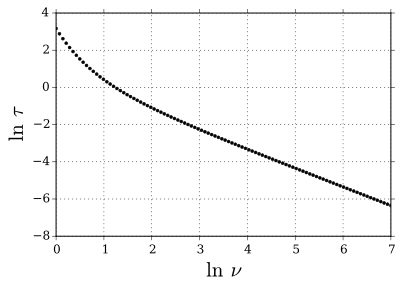

In [51]:
# Max ln nu to consider
log_nu_max = 7.0

# Set up range of values of nu to consider
log_nu = np.linspace(0, log_nu_max, 100)

# Consider interval with 99% of probability
f = 0.99

# Compute intervals for Student-t and Gaussian
int_student =  scipy.stats.t.interval(f, np.exp(log_nu), 0, 1)
int_gauss = scipy.stats.norm.interval(f, 0, 1)

# Get tailedness
tau = int_student[0] / int_gauss[0] - 1.0
log_tau = np.log(tau)

# Plot result
plt.plot(log_nu, log_tau, 'k.')
plt.xlabel(r'$\ln \, \nu$')
plt.ylabel(r'$\ln\,\tau$')
plt.grid(True)

If we take $\tau$ to have a uniform prior, i.e., $P(\tau) = \text{constant}$, then

\begin{align}
P(\nu) = P(\tau)\left|\frac{\mathrm{d}\tau}{\mathrm{d}\nu}\right| \propto
\left|\frac{\mathrm{d}\tau}{\mathrm{d}\nu}\right|.
\end{align}

It is more convenient to work in terms of $\ln \nu$ and $\ln \nu$.  So, we write

\begin{align}
P(\nu) \propto \frac{1}{\nu}\left|\frac{\mathrm{d}\ln \tau}{\mathrm{d}\ln \nu}\right|\mathrm{e}^{\ln \tau}.
\end{align}

Thus,

\begin{align}
\ln P(\nu) = \text{constant} - \ln \nu + \tau +\ln\left|\frac{\mathrm{d}\ln \tau}{\mathrm{d}\ln \nu}\right|.
\end{align}

For large $\nu$, as we can see from the above plot, $\tau \sim \nu^{-1}$ and $\mathrm{d}\ln \tau/\mathrm{d}\ln \nu \approx -1$.  So, for large $\nu$, $\ln P(\nu) \approx -\ln \nu$, and $P(\nu)$ is like a Jeffreys prior.  For smaller $\nu$, the three terms in the above expression are of similar magnitude, so we need to consider all of them.  We can just compute $\ln P(\nu)$ from the values of \tau we already computed.  We have to be a bit careful with the derivative calculation by finite differences because we want to be sure to include $\nu = 1$.  At that point, we will use forward differencing and central differencing for the rest of the points.

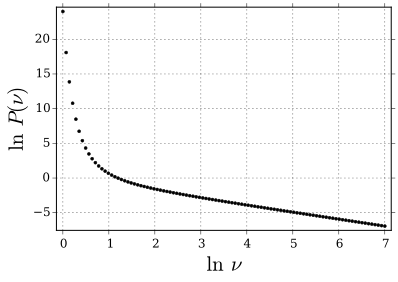

In [19]:
# Set up derivative array
derivs = np.empty(100)

# Forward differencing on ln tau = 0 point
derivs[0] = (-3.0 * log_tau[0] + 4.0 * log_tau[1] - log_tau[2]) / 2.0

# Backward differencing on ln tau = 7 point
derivs[-1] = (log_tau[-3] - 4.0 * log_tau[-2] + 3.0 * log_tau[-1]) / 2.0

# Central differencing on all other points
derivs[1:-1] = (-log_tau[:-2] + log_tau[2:]) / 2.0

# Compute log_P_nu
log_P_nu = -log_nu + tau + np.abs(derivs)

# Plot result
plt.plot(log_nu, log_P_nu, 'k.')
plt.grid(True)
plt.margins(0.02)
plt.xlabel(r'$\ln\, \nu$')
plt.ylabel(r'$\ln\,P(\nu)$')

In order to rapidly calculation $P(\nu)$ during an MCMC run, we need to make an interpolant of our numerically calculated $P(\nu)$ that we can quickly evaluate.  We won't use anything fancy, and will just use `scipy.interpolate.interp1d` to get an interpolant function using a cubic spline.

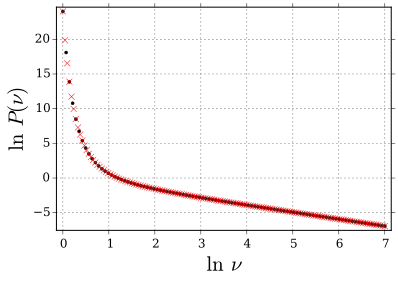

In [20]:
# Make interpolating function
log_P_nu_interp = scipy.interpolate.interp1d(log_nu, log_P_nu, kind='cubic')

# Plot the result
log_nu_plot = np.linspace(0, log_nu_max, 150)
plt.plot(log_nu, log_P_nu, 'k.')
plt.plot(log_nu_plot, log_P_nu_interp(log_nu_plot), 'rx')
plt.grid(True)
plt.margins(0.02)
plt.xlabel(r'$\ln\, \nu$')
plt.ylabel(r'$\ln\,P(\nu)$')

Putting it all together, we can now write a function for the prior on $\nu$.

In [21]:
# Function to give prior on nu, given the interp of ln P(nu) for small nu
def log_nu_prior(nu, log_nu_max, interp_fun):
    log_nu = np.log(nu)
    if log_nu >= log_nu_max:
        return -log_nu
    else:
        return interp_fun(log_nu)

We are now ready to define our posterior and do MCMC!

In [41]:
# Load data
df = pd.read_csv('linear_data_with_outliers.csv')

# Define log posterior
def log_posterior(p, x, y, log_nu_max, interp_fun):
    """
    Log posterior for fitting linear model with Student-t distributed data.
    """
    # Extract parameters
    a, b, beta, nu = p
    
    # Number of data points for convenience
    n = len(x)

    # Check prior
    if beta <= 0.0 or beta > y.max() or nu < 1.0:
        return -np.inf
    
    # Compute prior
    log_prior = log_nu_prior(nu, log_nu_max, interp_fun) - np.log(beta) \
                        -1.5 * np.log(1.0 + a**2)
    
    # Compute likelihood
    log_like = -n * np.log(beta) \
               - n / 2.0 * np.log(nu) \
               - n * scipy.special.betaln(0.5, nu / 2.0) \
               - (nu + 1.0) / 2.0 \
               * np.sum(np.log(1.0 + ((y - a * x - b) / beta)**2 / nu))

    # Return posterior
    return log_prior + log_like

# MCMC set-up
# Define walker settings
n_dim = 4        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 20000    # "burn-in" period to let chains stabilize
n_steps = 500000  # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
# We'll randomize in a Gaussian fashion about our guesses.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.0, 5.0, n_walkers)     # slope
p0[:,1] = np.random.uniform(0.0, 20.0, n_walkers)   # intercept
p0[:,2] = np.random.exponential(1.0, n_walkers)      # beta
p0[:,3] = 1.0 + np.random.uniform(1.0, 20.0, n_walkers)     # nu

# Set up the EnsembleSampler instance
outlier_sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                    args=(df.x, df.y, log_nu_max, log_P_nu_interp))

# Do the burn-in
pos, prob, state = outlier_sampler.run_mcmc(p0, n_burn, storechain=False)

# Reset sampler and run from the burn-in state we got to
outlier_sampler.reset()
pos, prob, state = outlier_sampler.run_mcmc(pos, n_steps)

We can compute the values of the tailedness $\tau$ from the trace.

In [53]:
# Compute tau
int_student =  scipy.stats.t.interval(f, 
                                      outlier_sampler.flatchain[:,3], 0, 1)
int_gauss = scipy.stats.norm.interval(f, 0, 1)
tau = int_student[0] / int_gauss[0] - 1.0

After a long calculation, it is often useful to save the important results, in this case the contents of `outlier_sampler`.  We can use `np.save` to do save NumPy arrays.  We will save `outlier_sampler.flatchain` and `outlier_sampler.flatlnprobability` so we have them for the future.

In [54]:
# Save arrays
np.save('hw5_outlier_flatchain.npy', outlier_sampler.flatchain)
np.save('hw5_outlier_flatlnprobability.npy', 
        outlier_sampler.flatlnprobability)
np.save('hw5_tau.npy', tau)

Just to demonstrate how to do it, we will now load the arrays from the `.npy` files.

In [55]:
flatchain = np.load('hw5_outlier_flatchain.npy')
flatlnprobability = np.load('hw5_outlier_flatlnprobability.npy')
tau = np.load('hw5_tau.npy')

Let's now check out our posterior distributions.

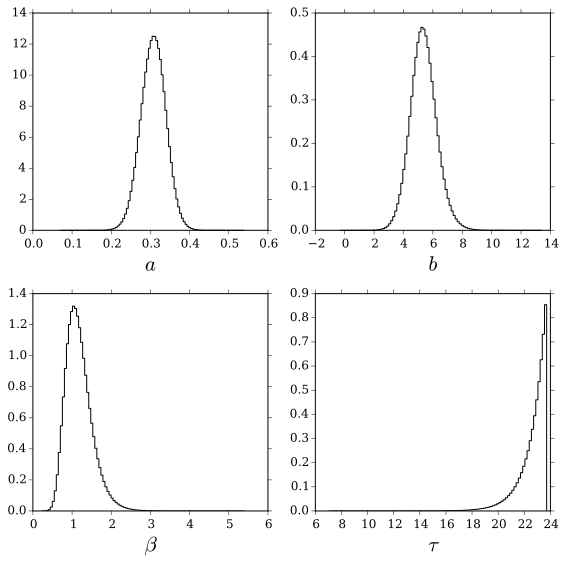

In [60]:
# Set up figure
fig, ax = plt.subplots(2, 2, figsize=(8,8))

n, bins, p = ax[0,0].hist(flatchain[:,0], normed=True, bins=100, 
                          histtype='step', color='k')
ax[0,0].set_xlabel('$a$')

n, bins, p = ax[0,1].hist(flatchain[:,1], normed=True, bins=100, 
                          histtype='step', color='k')
ax[0,1].set_xlabel('$b$')

n, bins, p = ax[1,0].hist(flatchain[:,2], normed=True, 
                          bins=100, histtype='step', color='k')
ax[1,0].set_xlabel(r'$\beta$')

n, bins, p = ax[1,1].hist(tau, normed=True, 
                          bins=100, histtype='step', color='k')
ax[1,1].set_xlabel(r'$\tau$')
plt.tight_layout()

We see from the distribution of $\tau$ that it strongly skews toward being long tailed.  This is not suprising, as the data have outliers.  The distribution of $\beta$ has a tail to the right, again due to the presense of outliers.

The distributions for $a$ and $b$ are unimodal, so let's check to see how closely they match Gaussian distributions.


a = 0.307 +- 0.032
b = 5.364 +- 0.906



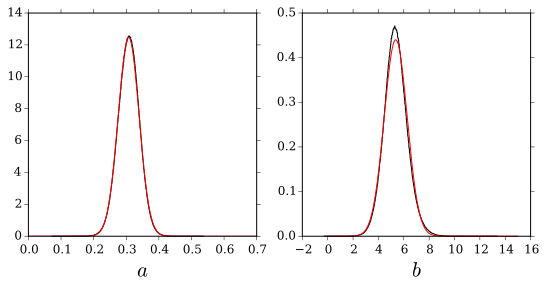

In [65]:
# Compute mean and std of a and b
a = flatchain[:,0].mean()
b = flatchain[:,1].mean()
a_err = flatchain[:,0].std()
b_err = flatchain[:,1].std()

# Report results
print("""
a = {0:.3f} +- {1:.3f}
b = {2:.3f} +- {3:.3f}
""".format(a, a_err, b, b_err))

# Make smooth curves
a_smooth = np.linspace(0.0, 0.7, 200)
a_gauss = np.exp(-(a_smooth - a)**2 / 2.0 / a_err**2) \
                / np.sqrt(2.0 * np.pi) / a_err
b_smooth = np.linspace(0.0, 15.0, 200)
b_gauss = np.exp(-(b_smooth - b)**2 / 2.0 / b_err**2) \
                / np.sqrt(2.0 * np.pi) / b_err
    
# Plot Gaussian curves on top
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
n, bins, p = ax[0].hist(flatchain[:,0], 
                        normed=True, bins=600, histtype='step', color='k')
ax[0].set_xlabel('$a$')
ax[0].plot(a_smooth, a_gauss, 'r-', lw=1)

n, bins, p = ax[1].hist(flatchain[:,1], 
                        normed=True, bins=600, histtype='step', color='k')
ax[1].set_xlabel('$b$')
ax[1].plot(b_smooth, b_gauss, 'r-', lw=1)

The distribution for $a$ is very close to Gaussian, while the distribution for $b$ has a slight tail to the right due to the outliers.  Nonetheless, we will use the reported mean $\pm$ standard deviation values of $a$ and $b$.  We can now plot our regression line.

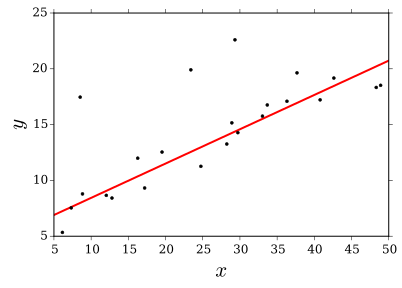

In [66]:
# Make a smooth line
x_fit = np.array([5.0, 50.0])
y_fit = a * x_fit + b

# Plot results
plt.plot(df.x, df.y, 'k.', zorder=1)
plt.plot(x_fit, y_fit, 'r-', zorder=0)
plt.xlabel('$x$')
plt.ylabel('$y$');

We pass the eye test: the procedure successfully dealt with the outliers.  Finally, we can make a summary plot to see how $a$ and $b$ are related to each other.

In [67]:
fig = triangle.corner(flatchain[:,:3], 
                      labels=[u'$a$', u'$b$', r'$\beta$'])